### **End To End Machine Learning Project**

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Handson_ML")

### **GET DATA**

In [ ]:
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close

In [ ]:
fetch_housing_data()

In [ ]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

In [ ]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### **Early Data Analysis**

In [ ]:
# Get data info
# total bedroom column is missing 207 data entries
# all features are numeric except for ocean_proximity
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
# ocean_proximity is a categorical feature
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


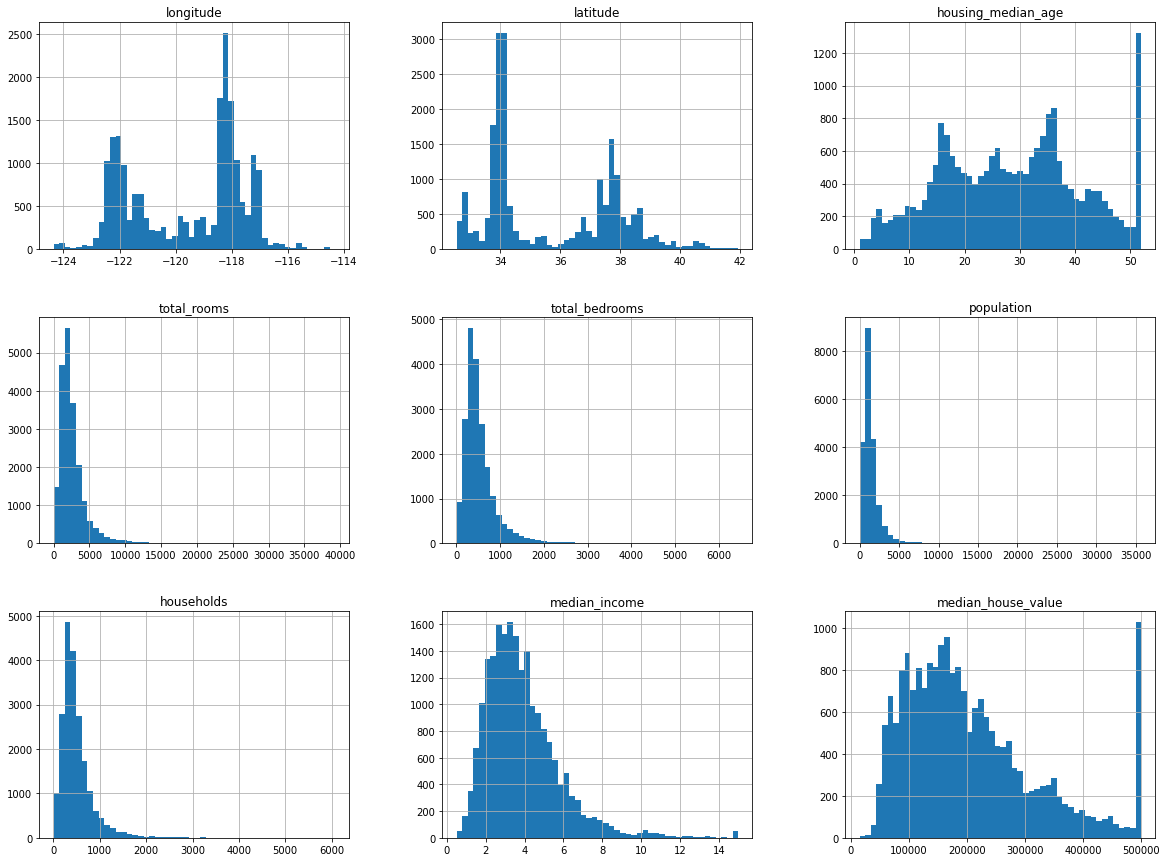

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 
housing.hist(bins=50, figsize=(20, 15))
plt.show()

[Key Points]
- median_income is not in $US, rather its in 10,000 USD.
- housing mediand and median house value has min/max range, which results in the spike at the end
  * In this case, either get the correct exact data or eliminate data with max value for training and testing
- scaling of the features are different
- a lot of features have long tails

### **Making test set**

#### few different ways to implement train-test split

In [ ]:
# using numpy, but this method has trouble when data is updated
import numpy as np

np.random.seed(42) # to get the same split everytime

def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data)*(test_ratio))
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


In [ ]:
# use hash
from zlib import crc32

def test_set_check(identifier, test_ratio):
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio*2**32

def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index() # this returns a column with index

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

print(len(train_set))
print(len(test_set))

# alternatively, can use a combination of longitutde and latitude
# housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

16512
4128


In [ ]:
# sklearn also provides train test split, pass in random state and dataframes with same number of columns
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print(len(train_set))
print(len(test_set))

16512
4128


In [ ]:
# stratifie sampling is important when dataset is not big enough that random sampling will not represent the whole data

from sklearn.model_selection import StratifiedShuffleSplit

housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6, np.inf],
                               labels=[1,2,3,4,5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # use split.split(X, y) to get train and test set
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

strat_test_set["income_cat"].value_counts() / len(strat_test_set)


3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

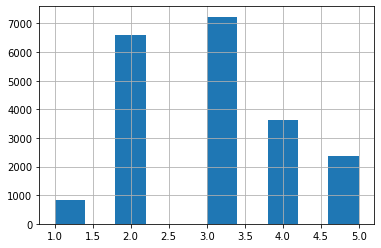

In [ ]:
housing["income_cat"].hist()

In [ ]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

### **Discover and Visualize Data**

In [ ]:
# explore only the train set
housing = strat_train_set.copy()

#### visualize geographic data

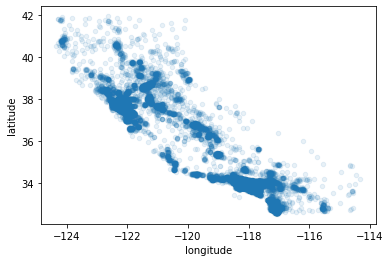

In [ ]:
# use alpha to get an idea on density
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

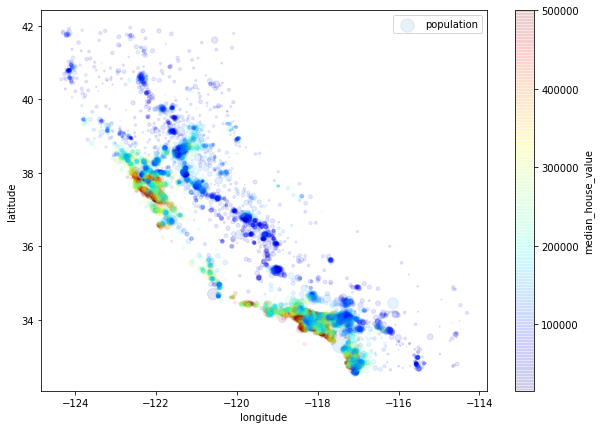

In [ ]:
# add population size, and housing prices
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, 
             s=housing["population"] / 100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, 
             sharex=False
)
# sharex makes x axes values to not overlap

plt.legend()

In [ ]:
# Download the California image
PROJECT_ROOT_DIR = "."
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7f5d3c893128>)

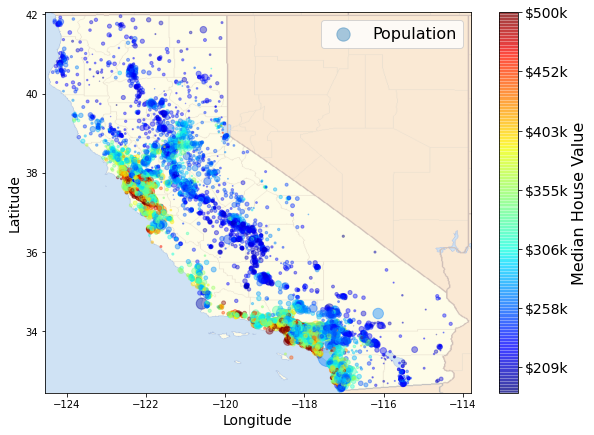

In [ ]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

#### Examine correlations

In [ ]:
corr_matrix = housing.corr()

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d3c8a3630>,
      dtype=object)

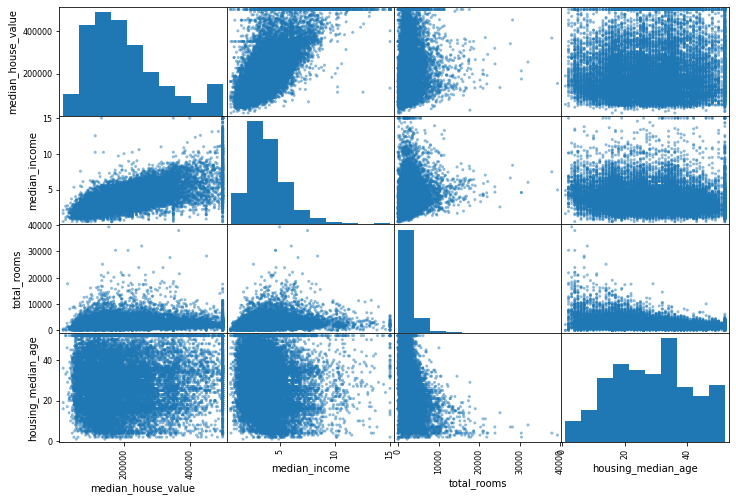

In [ ]:
# plot scatter matrix for columns with high positive correlations
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", 
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

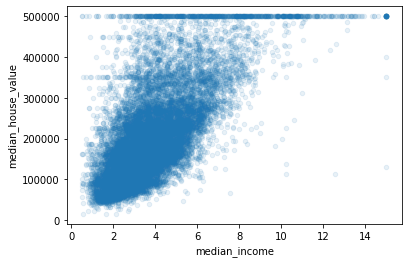

In [ ]:
# looks like median house value has high correlation with median income,
# focue on median income

housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

- clear and strong correlation is visible
- max limit of 500,000 is visible
- looks like there is a line-like data for house value = 450,000, 350,000, and 280,000. its better to eliminate them

#### Feature combinations

In [ ]:
# get more useful features out of existing features
# i.e. rooms per household, bedrooms per room, population per household

housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

- Not bad, rooms per household has positive and higher correlation than just total rooms
- bedrooms per room has negative correlations, more rooms probably meant more luxurious

### **Data Preparation**

In [ ]:
# seperate features and target variable
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
# data preprocessing
# for null values, either eliminate data, get rid of the feature column or fill in with another value 
# use dropna(), drop(), or fillna()

# option 1
# housing.dropna(subset=["total_bedrooms"])

# option 2
# housing.drop("total_bedrooms", axis=1)

# option 3
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True)


In [ ]:
# Can also use sklearn simpleimputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# remove text attributes
housing_num = housing.drop("ocean_proximity", axis=1)

#use fit method
imputer.fit(housing_num)
print(imputer.statistics_)
print(housing_num.median().values)

X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


#### Dealing with text and categorical data

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [ ]:
# can use OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
# OrdinalEncoder contains order, which might be misleading
# so OneHotEncoding could be better
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
# OneHotEncoder returns sparse matrix, to get actual matrix, use toarray()
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
# custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombineAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True):
    self.add_bedrooms_per_room = add_bedrooms_per_room
  
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    
    else:
      return np.c_[X, rooms_per_household, population_per_household]
    
attr_adder = CombineAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)
  


#### Feature Scaling

In [ ]:
# there are min-max standarization, and normalization
# for scaling, scale fit only on the training data and tranform the train set and test set

#using pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy="median")),
                         ('attribs_adder', CombineAttributesAdder()),
                         ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing_num_tr[:10]

array([[-1.15604281e+00,  7.71949616e-01,  7.43330892e-01,
        -4.93233934e-01, -4.45438207e-01, -6.36211407e-01,
        -4.20698422e-01, -6.14937444e-01, -3.12054519e-01,
        -8.64987054e-02,  1.55317530e-01],
       [-1.17602483e+00,  6.59694795e-01, -1.16531720e+00,
        -9.08966554e-01, -1.03692780e+00, -9.98331347e-01,
        -1.02222705e+00,  1.33645936e+00,  2.17683377e-01,
        -3.35339129e-02, -8.36289016e-01],
       [ 1.18684903e+00, -1.34218285e+00,  1.86641864e-01,
        -3.13659889e-01, -1.53344583e-01, -4.33639362e-01,
        -9.33177983e-02, -5.32045602e-01, -4.65315160e-01,
        -9.24049941e-02,  4.22200402e-01],
       [-1.70676728e-02,  3.13575763e-01, -2.90520160e-01,
        -3.62762167e-01, -3.96755937e-01,  3.60409561e-02,
        -3.83435587e-01, -1.04556555e+00, -7.96612428e-02,
         8.97356110e-02, -1.96453142e-01],
       [ 4.92473835e-01, -6.59299356e-01, -9.26736191e-01,
         1.85619316e+00,  2.41221109e+00,  2.72415407e+00,
  

In [ ]:
# sklearn also has transformer for columns
# use passthrough to pass colulmns
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
                                   ("num", num_pipeline, num_attribs),
                                   ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

### **Select Model and Train**

In [ ]:
# train with train set and test
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("predicted:", lin_reg.predict(some_data_prepared))
print("actual:", list(some_labels))

predicted: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
actual: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [ ]:
# calculate mean_square_error
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

- considering housing price is between 120,000 and 265,000. This looks like a underfit

In [ ]:
# try on DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

- Model probably overfitted on the training set for this one

#### using corss validation

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
  print("score:", scores)
  print("average:", scores.mean())
  print("STD:", scores.std())

display_scores(tree_rmse_scores)

score: [69327.01708558 65486.39211857 71358.25563341 69091.37509104
 70570.20267046 75529.94622521 69895.20650652 70660.14247357
 75843.74719231 68905.17669382]
average: 70666.74616904806
STD: 2928.322738055112


In [ ]:
# linear model seems a little better than tree regression
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

score: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
average: 69052.46136345083
STD: 2731.674001798344


In [ ]:
# tree RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)



18837.350858497157


In [ ]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

score: [49528.46835363 47539.55657944 49787.74763811 52011.16427205
 49411.96233013 53544.11297961 48907.4166229  48159.12757986
 53051.07053608 50463.16616994]
average: 50240.37930617386
STD: 1918.3525155434513


### **Fine Tuning the Model**

#### GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'n_estimators':[3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
# above trains on 12 + 6 models
# get the best param
# if refit=True on GridSearchCV it will retrain the model with the best param

grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [ ]:
# can also check the results
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres["params"]):
  print(np.sqrt(-mean_score), params)

63704.59589341461 {'max_features': 2, 'n_estimators': 3}
55697.12200082165 {'max_features': 2, 'n_estimators': 10}
52838.3329098239 {'max_features': 2, 'n_estimators': 30}
59553.012607291326 {'max_features': 4, 'n_estimators': 3}
52621.63082661913 {'max_features': 4, 'n_estimators': 10}
50627.15802131442 {'max_features': 4, 'n_estimators': 30}
59566.674096232455 {'max_features': 6, 'n_estimators': 3}
52436.04807949553 {'max_features': 6, 'n_estimators': 10}
50150.76302348018 {'max_features': 6, 'n_estimators': 30}
59131.18981562578 {'max_features': 8, 'n_estimators': 3}
52155.88422504105 {'max_features': 8, 'n_estimators': 10}
50104.6064499928 {'max_features': 8, 'n_estimators': 30}
63296.28372459558 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54833.66362237186 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59494.0958605207 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52092.48123310486 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}

In [ ]:
## instead of gridsearch, you can also do random search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


#### best model and error analysis

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.16464078e-02, 5.97745374e-02, 4.34345210e-02, 1.54659834e-02,
       1.50236002e-02, 1.46652378e-02, 1.47367608e-02, 3.81826468e-01,
       4.45883024e-02, 1.11443673e-01, 7.48553026e-02, 7.57703658e-03,
       1.37478571e-01, 1.02190929e-04, 2.08803585e-03, 5.29337110e-03])

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)


[(0.3818264676437279, 'median_income'),
 (0.13747857105737155, 'INLAND'),
 (0.11144367341734038, 'pop_per_hhold'),
 (0.07485530262365697, 'bedrooms_per_room'),
 (0.07164640778075951, 'longitude'),
 (0.05977453744272732, 'latitude'),
 (0.04458830242275313, 'rooms_per_hhold'),
 (0.04343452095156232, 'housing_median_age'),
 (0.015465983419094161, 'total_rooms'),
 (0.015023600170780176, 'total_bedrooms'),
 (0.014736760784386273, 'households'),
 (0.01466523783873149, 'population'),
 (0.007577036575367064, '<1H OCEAN'),
 (0.005293371095534136, 'NEAR OCEAN'),
 (0.0020880358476394393, 'NEAR BAY'),
 (0.00010219092856820283, 'ISLAND')]

- it is visible that only ocean_proximity category is actally important
- feature importance helps to narrow down more important features

#### Final model evaluation with testset

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(final_rmse)

47838.88159026728


In [ ]:
# get confidence interval for the result
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors) -1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45853.46602299, 49745.11872831])

### MORE PRACTICES

In [ ]:
from sklearn.svm import SVR

param_grid = [ 
              {'kernel':["linear"], 'C':[10, 30, 100, 300, 1000, 3000, 10000, 30000]},
              {'kernel':["rbf"], 'C':[1, 3, 10, 30, 100, 300, 1000, 3000]},
              {'gamma':[0.01, 0.03, 0.1, 0.3, 1, 3]}
]

svr_reg = SVR()
grid_search = GridSearchCV(svr_reg, param_grid, cv=5, scoring="neg_mean_squared_error", verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 22 candidates, totalling 110 fits
[CV] C=10, kernel=linear .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=10, kernel=linear, total=  10.0s
[CV] C=10, kernel=linear .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


[CV] .............................. C=10, kernel=linear, total=  10.3s
[CV] C=10, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total=  10.1s
[CV] C=10, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total=   9.9s
[CV] C=10, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total=   9.9s
[CV] C=30, kernel=linear .............................................
[CV] .............................. C=30, kernel=linear, total=   9.7s
[CV] C=30, kernel=linear .............................................
[CV] .............................. C=30, kernel=linear, total=   9.7s
[CV] C=30, kernel=linear .............................................
[CV] .............................. C=30, kernel=linear, total=  10.0s
[CV] C=30, kernel=linear .............................................
[CV] .

[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed: 27.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [10, 30, 100, 300, 1000, 3000, 10000, 30000],
                          'kernel': ['linear']},
                         {'C': [1, 3, 10, 30, 100, 300, 1000, 3000],
                          'kernel': ['rbf']},
                         {'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
print(rmse)

grid_search.best_params_

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   9.8s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.8s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.0s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.1s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.0s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   9.9s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  19.3s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  19.8s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  19.5s
[CV] C=26290.2

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 100.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5d302155c0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5d30205860>,
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
print(rmse)

rnd_search.best_params_

54767.960710084146


{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

In [ ]:
# pipeline for selecting only the important attributes

def indices_of_top_k(arr, k):
  return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
  def __init__(self, feature_importances, k):
    self.feature_importances = feature_importances
    self.k = k
  
  def fit(self, X, y=None):
    self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
    return self
  
  def transform(self, X):
    return X[:, self.feature_indices_]



In [ ]:
k = 5

preparation_and_feature_selection_pipeline = Pipeline([
      ('preparation', full_pipeline),
      ('feature_selection', TopFeatureSelector(feature_importances, k))
])

housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [ ]:
# full pipeline from preparation to prediction
prepare_select_and_predict_pipeline = Pipeline([
      ('preparation', full_pipeline),
      ('feature_selection', TopFeatureSelector(feature_importances, k)),
      ('svm_reg', SVR(**rnd_search.best_params_))
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print(prepare_select_and_predict_pipeline.predict(some_data))
print(list(some_labels))

[185384.13066634 341000.56131537 172531.39955817  56040.55006167]
[286600.0, 340600.0, 196900.0, 46300.0]


In [ ]:
# explore some preparation options using GridSearchCV
param_grid = [{
    'preparation__num__imputer__strategy':['mean', 'median', 'most_frequent'],
    'feature_selection__k':list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid,
                                cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.1s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=  12.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=  12.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 100.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                     